In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

#### 2.3.1. Загрузка данных и первичный анализ (для каждого датасета)

Для **каждого** из 3 выбранных CSV:

1) Загрузить CSV в `pandas.DataFrame`.  
2) Зафиксировать минимум:
   - `head()`, `info()`, базовые статистики (`describe()` или аналог);
   - проверка пропусков (кол-во/доли);
   - типы признаков (числовые / категориальные).  
3) Определить:
   - `X` – признаки (все столбцы, кроме `sample_id`);
   - `sample_id` хранить отдельно (для сохранения результатов).

# Датасет №1 - `S07-hw-dataset-01.csv`  
  Числовые признаки в разных шкалах + шумовые признаки. Без масштабирования результаты обычно "едут".

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_dir = '/content/drive/MyDrive/seminars/S07'
os.chdir(base_dir)

print("Текущая директория:", os.getcwd())

df_01 = pd.read_csv('S07-hw-dataset-01.csv')

Текущая директория: /content/drive/MyDrive/seminars/S07


In [4]:
print(f"Размер датасета (shape): {df_01.shape}")
print(f"Количество строк: {df_01.shape[0]}")
print(f"Количество столбцов: {df_01.shape[1]}")

Размер датасета (shape): (12000, 9)
Количество строк: 12000
Количество столбцов: 9


In [5]:
df_01.head()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [6]:
df_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [16]:
df_01.describe().round(2)

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,5999.50,-2.42,19.11,-0.22,-8.28,-0.19,0.96,0.03,0.01
std,3464.25,11.01,60.79,0.50,59.27,7.03,14.79,59.54,0.61
min,0.00,-19.91,-92.89,-1.59,-134.30,-11.87,-20.52,-215.10,-2.63
25%,2999.75,-9.47,-40.28,-0.13,-48.35,-5.13,-8.81,-39.90,-0.40
50%,5999.50,-6.87,54.07,-0.03,16.21,0.44,-6.13,-0.58,0.01
75%,8999.25,0.52,70.28,0.05,28.07,3.94,2.33,39.72,0.41
max,11999.00,24.40,112.23,0.51,75.09,13.72,41.45,213.38,2.49


In [8]:
df_01.isnull().sum()

,0
sample_id,0
f01,0
f02,0
f03,0
f04,0
f05,0
f06,0
f07,0
f08,0


In [10]:
sample_ids_01 = df_01["sample_id"]
X_01 = df_01.drop(columns=["sample_id"])
# Типы данных по колонкам
print("Типы данных признаков:")
display(X_01.dtypes)
# Подсчет типов признаков
print("\nКоличественная информация о признаках:")
numeric_cols = X_01.select_dtypes(include=[np.number]).columns
categorical_cols = X_01.select_dtypes(exclude=[np.number]).columns
print(f"Числовых признаков: {len(numeric_cols)}")
print(f"Категориальных признаков: {len(categorical_cols)}")

Типы данных признаков:


,0
f01,float64
f02,float64
f03,float64
f04,float64
f05,float64
f06,float64
f07,float64
f08,float64



Количественная информация о признаках:
Числовых признаков: 8
Категориальных признаков: 0


# Датасет №2 - `S07-hw-dataset-02.csv`  
  Нелинейная структура + выбросы + лишний шумовой признак. Хорошо демонстрирует, где KMeans проигрывает.

In [11]:
base_dir = '/content/drive/MyDrive/seminars/S07'
os.chdir(base_dir)

print("Текущая директория:", os.getcwd())

df_02 = pd.read_csv('S07-hw-dataset-02.csv')

Текущая директория: /content/drive/MyDrive/seminars/S07


In [12]:
print(f"Размер датасета (shape): {df_02.shape}")
print(f"Количество строк: {df_02.shape[0]}")
print(f"Количество столбцов: {df_02.shape[1]}")

Размер датасета (shape): (8000, 4)
Количество строк: 8000
Количество столбцов: 4


In [13]:
df_02.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [14]:
df_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [15]:
df_02.describe().round(2)

,sample_id,x1,x2,z_noise
count,8000.00,8000.00,8000.00,8000.00
mean,3999.50,0.48,0.24,0.11
std,2309.55,0.96,0.66,8.10
min,0.00,-2.49,-2.50,-34.06
25%,1999.75,-0.12,-0.24,-5.39
50%,3999.50,0.49,0.24,0.13
75%,5999.25,1.09,0.73,5.66
max,7999.00,2.99,3.00,29.46


In [17]:
df_02.isnull().sum()

,0
sample_id,0
x1,0
x2,0
z_noise,0


In [18]:
sample_ids_02 = df_02["sample_id"]
X_02 = df_02.drop(columns=["sample_id"])
# Типы данных по колонкам
print("Типы данных признаков:")
display(X_02.dtypes)
# Подсчет типов признаков
print("\nКоличественная информация о признаках:")
numeric_cols = X_02.select_dtypes(include=[np.number]).columns
categorical_cols = X_02.select_dtypes(exclude=[np.number]).columns
print(f"Числовых признаков: {len(numeric_cols)}")
print(f"Категориальных признаков: {len(categorical_cols)}")

Типы данных признаков:


,0
x1,float64
x2,float64
z_noise,float64



Количественная информация о признаках:
Числовых признаков: 3
Категориальных признаков: 0


# Датасет №3 - `S07-hw-dataset-03.csv`
Кластеры разной плотности + фоновый шум. Часто провоцирует ошибки выбора `eps` для DBSCAN.

In [19]:
base_dir = '/content/drive/MyDrive/seminars/S07'
os.chdir(base_dir)

print("Текущая директория:", os.getcwd())

df_03 = pd.read_csv('S07-hw-dataset-03.csv')

Текущая директория: /content/drive/MyDrive/seminars/S07


In [20]:
print(f"Размер датасета (shape): {df_03.shape}")
print(f"Количество строк: {df_03.shape[0]}")
print(f"Количество столбцов: {df_03.shape[1]}")

Размер датасета (shape): (15000, 5)
Количество строк: 15000
Количество столбцов: 5


In [21]:
df_03.head()

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [22]:
df_03.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [23]:
df_03.describe().round(2)

,sample_id,x1,x2,f_corr,f_noise
count,15000.00,15000.00,15000.00,15000.00,15000.00
mean,7499.50,1.25,1.03,0.21,-0.03
std,4330.27,4.59,4.71,1.53,2.51
min,0.00,-10.00,-9.98,-5.21,-8.79
25%,3749.75,-1.78,-2.67,-0.97,-1.73
50%,7499.50,0.66,1.83,0.30,-0.05
75%,11249.25,4.44,4.97,1.39,1.67
max,14999.00,16.21,14.27,5.80,11.27


In [24]:
df_03.isnull().sum()

,0
sample_id,0
x1,0
x2,0
f_corr,0
f_noise,0


In [25]:
sample_ids_03 = df_03["sample_id"]
X_03 = df_03.drop(columns=["sample_id"])
# Типы данных по колонкам
print("Типы данных признаков:")
display(X_03.dtypes)
# Подсчет типов признаков
print("\nКоличественная информация о признаках:")
numeric_cols = X_03.select_dtypes(include=[np.number]).columns
categorical_cols = X_03.select_dtypes(exclude=[np.number]).columns
print(f"Числовых признаков: {len(numeric_cols)}")
print(f"Категориальных признаков: {len(categorical_cols)}")

Типы данных признаков:


,0
x1,float64
x2,float64
f_corr,float64
f_noise,float64



Количественная информация о признаках:
Числовых признаков: 4
Категориальных признаков: 0


#### 2.3.2. Препроцессинг (обязательно)

Для каждого датасета оформите препроцессинг **явно** и применяйте его одинаково ко всем моделям данного датасета.

Минимум:

- масштабирование числовых признаков: `StandardScaler`;
- если есть пропуски – обработать (`SimpleImputer`);
- если есть категориальные признаки (dataset-04) – один из вариантов:
  - закодировать (`OneHotEncoder(handle_unknown="ignore")`), **или**
  - осознанно исключить категориальные признаки и объяснить почему (в отчёте).

Рекомендация: использовать `Pipeline`/`ColumnTransformer` (не обязательно идеально, но логика должна быть понятной).

# Датасет 1

In [26]:
print("Препроцессинг датасета 01")

# Проверяем пропуски
print(f"Пропуски: {X_01.isnull().sum().sum()}")

# Создаем пайплайн
preprocessor_01 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Применяем
X_01_processed = preprocessor_01.fit_transform(X_01)
print(f"Размер: {X_01.shape} → {X_01_processed.shape}")

Препроцессинг датасета 01
Пропуски: 0
Размер: (12000, 8) → (12000, 8)


# Датасет 2

In [27]:
print("Препроцессинг датасета 02")

# Проверяем пропуски
print(f"Пропуски: {X_02.isnull().sum().sum()}")

# Создаем пайплайн
preprocessor_02 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Применяем
X_02_processed = preprocessor_02.fit_transform(X_02)
print(f"Размер: {X_02.shape} → {X_02_processed.shape}")

Препроцессинг датасета 02
Пропуски: 0
Размер: (8000, 3) → (8000, 3)


# Датасет 3

In [28]:
print("Препроцессинг датасета 03")

# Проверяем пропуски
print(f"Пропуски: {X_03.isnull().sum().sum()}")

# Создаем пайплайн
preprocessor_03 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Применяем
X_03_processed = preprocessor_03.fit_transform(X_03)
print(f"Размер: {X_03.shape} → {X_03_processed.shape}")

Препроцессинг датасета 03
Пропуски: 0
Размер: (15000, 4) → (15000, 4)


In [29]:
# Проверяем, что данные действительно масштабированы
# Для датасета 01
print("Проверка масштабирования датасета 01:")
print(f"Среднее: {np.mean(X_01_processed, axis=0).round(2)}")
print(f"Станд. отклонение: {np.std(X_01_processed, axis=0).round(2)}")

# Для датасета 02
print("\nПроверка масштабирования датасета 02:")
print(f"Среднее: {np.mean(X_02_processed, axis=0).round(2)}")
print(f"Станд. отклонение: {np.std(X_02_processed, axis=0).round(2)}")

# Для датасета 03
print("\nПроверка масштабирования датасета 03:")
print(f"Среднее: {np.mean(X_03_processed, axis=0).round(2)}")
print(f"Станд. отклонение: {np.std(X_03_processed, axis=0).round(2)}")

Проверка масштабирования датасета 01:
Среднее: [ 0. -0. -0. -0. -0.  0. -0. -0.]
Станд. отклонение: [1. 1. 1. 1. 1. 1. 1. 1.]

Проверка масштабирования датасета 02:
Среднее: [-0.  0. -0.]
Станд. отклонение: [1. 1. 1.]

Проверка масштабирования датасета 03:
Среднее: [ 0.  0.  0. -0.]
Станд. отклонение: [1. 1. 1. 1.]


#### 2.3.3. Модели недели 7 (для каждого датасета – минимум 2 алгоритма)

Для **каждого датасета** сравните минимум **2** алгоритма:

1) **KMeans** (обязательно):
   - подобрать `k` в разумном диапазоне (например, 2…20);
   - фиксировать `random_state` и `n_init`;
   - показать хотя бы один график "метрика vs k" (например, silhouette vs k).

2) **Один алгоритм на выбор** (обязательно):
   - `DBSCAN` (подбор `eps` и `min_samples`), **или**
   - `AgglomerativeClustering` (подбор `k` + выбор `linkage`, хотя бы 2 варианта).

# Датасет 1

ДАТАСЕТ 01: KMeans + DBSCAN

1. KMEANS:


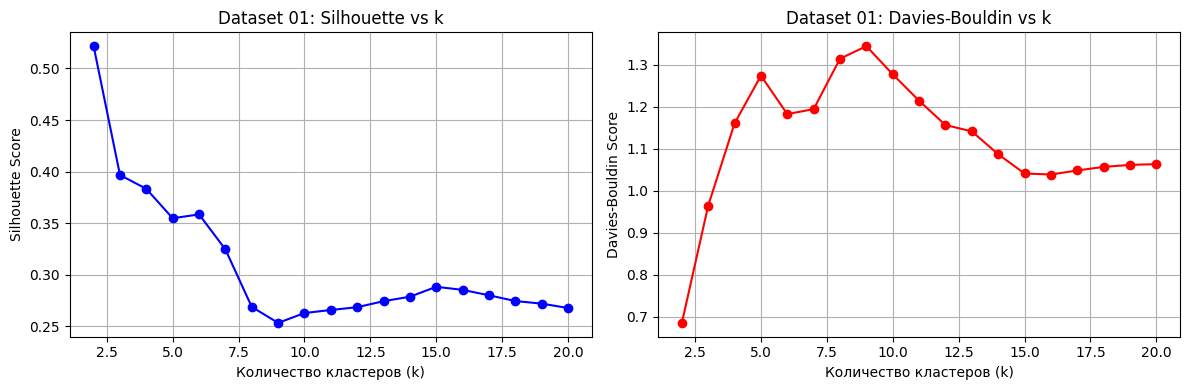

Лучшее k: 2 (Silhouette=0.522)

2. DBSCAN (подбор параметров):
Лучшие параметры: eps=1.00, min_samples=10
Silhouette: 0.383
СРАВНЕНИЕ АЛГОРИТМОВ

KMeans (k=2):
  Silhouette: 0.522
  Davies-Bouldin: 0.685
  Calinski-Harabasz: 11787

DBSCAN (eps=1.00, min_samples=10):
  Кластеров: 4
  Шум: 8 точек
  Silhouette: 0.383
  Davies-Bouldin: 3.042
  Calinski-Harabasz: 7066


In [56]:
print("ДАТАСЕТ 01: KMeans + DBSCAN")


# 1. KMeans с подбором k (2…20)
print("\n1. KMEANS:")
k_range = range(2, 21)
silhouette_scores = []
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_01_processed)

    if len(set(labels)) > 1:
        silhouette_scores.append(silhouette_score(X_01_processed, labels))
        db_scores.append(davies_bouldin_score(X_01_processed, labels))

# Два графика: silhouette vs k и davies-bouldin vs k
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# График 1: Silhouette vs k
axes[0].plot(list(k_range), silhouette_scores, 'bo-')
axes[0].set_xlabel('Количество кластеров (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Dataset 01: Silhouette vs k')
axes[0].grid(True)

# График 2: Davies-Bouldin vs k
axes[1].plot(list(k_range), db_scores, 'ro-')
axes[1].set_xlabel('Количество кластеров (k)')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Dataset 01: Davies-Bouldin vs k')
axes[1].grid(True)

plt.tight_layout()
plt.show()

best_k = list(k_range)[np.argmax(silhouette_scores)]
print(f"Лучшее k: {best_k} (Silhouette={max(silhouette_scores):.3f})")

# 2. DBSCAN с подбором eps и min_samples
print("\n2. DBSCAN (подбор параметров):")

# Подбираем eps и min_samples
eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = [5, 10, 15]

best_eps = None
best_min_samples = None
best_score = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_01_processed)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1 and len(set(labels)) > 1:
            score = silhouette_score(X_01_processed, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Лучшие параметры: eps={best_eps:.2f}, min_samples={best_min_samples}")
print(f"Silhouette: {best_score:.3f}")

# Сравнение результатов
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)

kmeans_labels = kmeans_best.fit_predict(X_01_processed)
dbscan_labels = dbscan_best.fit_predict(X_01_processed)


print("СРАВНЕНИЕ АЛГОРИТМОВ")


print(f"\nKMeans (k={best_k}):")
print(f"  Silhouette: {silhouette_score(X_01_processed, kmeans_labels):.3f}")
print(f"  Davies-Bouldin: {davies_bouldin_score(X_01_processed, kmeans_labels):.3f}")
print(f"  Calinski-Harabasz: {calinski_harabasz_score(X_01_processed, kmeans_labels):.0f}")

print(f"\nDBSCAN (eps={best_eps:.2f}, min_samples={best_min_samples}):")
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"  Кластеров: {n_clusters_dbscan}")
print(f"  Шум: {np.sum(dbscan_labels == -1)} точек")
if len(set(dbscan_labels)) > 1:
    print(f"  Silhouette: {silhouette_score(X_01_processed, dbscan_labels):.3f}")
    print(f"  Davies-Bouldin: {davies_bouldin_score(X_01_processed, dbscan_labels):.3f}")
    print(f"  Calinski-Harabasz: {calinski_harabasz_score(X_01_processed, dbscan_labels):.0f}")

# Датасет 2

ДАТАСЕТ 02: KMeans + AgglomerativeClustering

1. KMEANS:


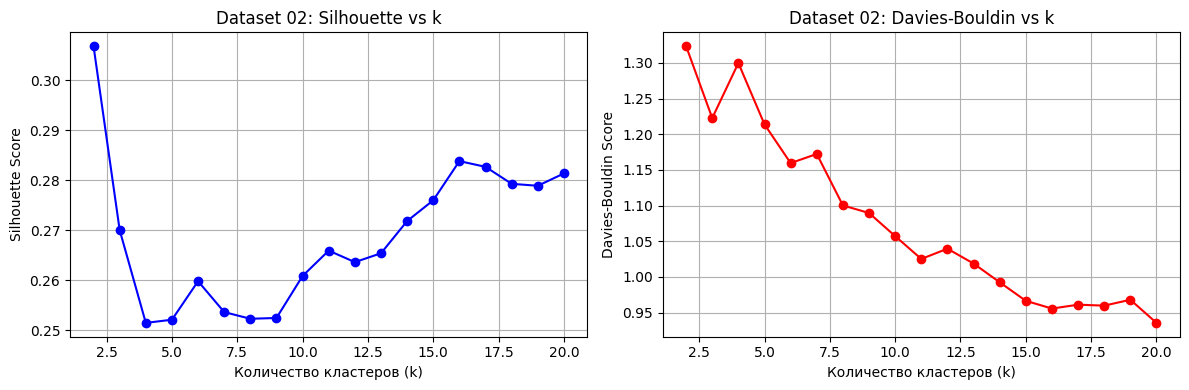

Лучшее k для KMeans: 2

2. AGGLOMERATIVE CLUSTERING (подбор k + выбор linkage):
  ward: лучший k=2, Silhouette=0.266
  complete: лучший k=6, Silhouette=0.211
  average: лучший k=2, Silhouette=0.420

Лучшая конфигурация: linkage='average', k=2
СРАВНЕНИЕ АЛГОРИТМОВ

KMeans (k=2):
  Silhouette: 0.307
  Davies-Bouldin: 1.323
  Calinski-Harabasz: 3573

Agglomerative (linkage='average', k=2):
  Silhouette: 0.420
  Davies-Bouldin: 0.879
  Calinski-Harabasz: 395


In [40]:
print("ДАТАСЕТ 02: KMeans + AgglomerativeClustering")

# 1. KMeans с подбором k (2…20)
print("\n1. KMEANS:")
k_range = range(2, 21)
silhouette_scores = []
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_02_processed)

    if len(set(labels)) > 1:
        silhouette_scores.append(silhouette_score(X_02_processed, labels))
        db_scores.append(davies_bouldin_score(X_02_processed, labels))

# Два графика
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(list(k_range), silhouette_scores, 'bo-')
axes[0].set_xlabel('Количество кластеров (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Dataset 02: Silhouette vs k')
axes[0].grid(True)

axes[1].plot(list(k_range), db_scores, 'ro-')
axes[1].set_xlabel('Количество кластеров (k)')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Dataset 02: Davies-Bouldin vs k')
axes[1].grid(True)

plt.tight_layout()
plt.show()

best_k_kmeans = list(k_range)[np.argmax(silhouette_scores)]
print(f"Лучшее k для KMeans: {best_k_kmeans}")

# 2. AgglomerativeClustering с разными linkage
print("\n2. AGGLOMERATIVE CLUSTERING (подбор k + выбор linkage):")

# Сравниваем минимум 2 варианта linkage
linkage_methods = ['ward', 'complete', 'average']
best_scores = {}
best_ks = {}

for linkage in linkage_methods:
    scores = []
    for k in range(2, 11):  # Подбираем k
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X_02_processed)

        if len(set(labels)) > 1:
            score = silhouette_score(X_02_processed, labels)
            scores.append(score)

    if scores:
        best_idx = np.argmax(scores)
        best_scores[linkage] = scores[best_idx]
        best_ks[linkage] = range(2, 11)[best_idx]
        print(f"  {linkage}: лучший k={best_ks[linkage]}, Silhouette={scores[best_idx]:.3f}")

# Выбираем лучший linkage
best_linkage = max(best_scores, key=best_scores.get)
best_k_agg = best_ks[best_linkage]

print(f"\nЛучшая конфигурация: linkage='{best_linkage}', k={best_k_agg}")

# Сравнение результатов
kmeans_best = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10)
agg_best = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_linkage)

kmeans_labels = kmeans_best.fit_predict(X_02_processed)
agg_labels = agg_best.fit_predict(X_02_processed)


print("СРАВНЕНИЕ АЛГОРИТМОВ")


print(f"\nKMeans (k={best_k_kmeans}):")
print(f"  Silhouette: {silhouette_score(X_02_processed, kmeans_labels):.3f}")
print(f"  Davies-Bouldin: {davies_bouldin_score(X_02_processed, kmeans_labels):.3f}")
print(f"  Calinski-Harabasz: {calinski_harabasz_score(X_02_processed, kmeans_labels):.0f}")

print(f"\nAgglomerative (linkage='{best_linkage}', k={best_k_agg}):")
print(f"  Silhouette: {silhouette_score(X_02_processed, agg_labels):.3f}")
print(f"  Davies-Bouldin: {davies_bouldin_score(X_02_processed, agg_labels):.3f}")
print(f"  Calinski-Harabasz: {calinski_harabasz_score(X_02_processed, agg_labels):.0f}")

# Датасет 3

ДАТАСЕТ 03: KMeans + DBSCAN

1. KMEANS:


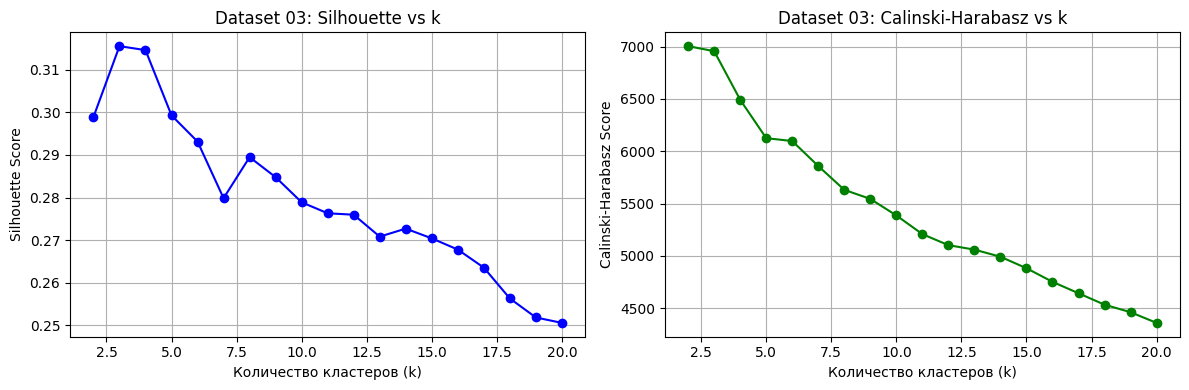

Лучшее k: 3 (Silhouette=0.316)

2. DBSCAN (подбор параметров для данных с разной плотностью):
Лучшие параметры: eps=0.80, min_samples=3
  Кластеров: 2, Шум: 0.1%
  Silhouette: 0.318
СРАВНЕНИЕ АЛГОРИТМОВ

KMeans (k=3):
  Silhouette: 0.316
  Davies-Bouldin: 1.158
  Calinski-Harabasz: 6957

DBSCAN (eps=0.80, min_samples=3):
  Кластеров: 2
  Шум: 22 точек (0.1%)
  Silhouette: 0.318
  Davies-Bouldin: 5.636
  Calinski-Harabasz: 10


In [39]:
print("ДАТАСЕТ 03: KMeans + DBSCAN")

# 1. KMeans с подбором k (2…20)
print("\n1. KMEANS:")
k_range = range(2, 21)
silhouette_scores = []
ch_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_03_processed)

    if len(set(labels)) > 1:
        silhouette_scores.append(silhouette_score(X_03_processed, labels))
        ch_scores.append(calinski_harabasz_score(X_03_processed, labels))

# Два графика
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(list(k_range), silhouette_scores, 'bo-')
axes[0].set_xlabel('Количество кластеров (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Dataset 03: Silhouette vs k')
axes[0].grid(True)

axes[1].plot(list(k_range), ch_scores, 'go-')
axes[1].set_xlabel('Количество кластеров (k)')
axes[1].set_ylabel('Calinski-Harabasz Score')
axes[1].set_title('Dataset 03: Calinski-Harabasz vs k')
axes[1].grid(True)

plt.tight_layout()
plt.show()

best_k = list(k_range)[np.argmax(silhouette_scores)]
print(f"Лучшее k: {best_k} (Silhouette={max(silhouette_scores):.3f})")

# 2. DBSCAN с подбором eps и min_samples
print("\n2. DBSCAN (подбор параметров для данных с разной плотностью):")

eps_values = np.linspace(0.3, 1.2, 10)
min_samples_values = [3, 5, 8, 10]

results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_03_processed)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = np.sum(labels == -1) / len(labels)

        if 2 <= n_clusters <= 8 and noise_ratio < 0.3:
            if len(set(labels)) > 1:
                score = silhouette_score(X_03_processed, labels)
                results.append((eps, min_samples, n_clusters, noise_ratio, score))

# Выбираем лучший результат
if results:
    best_result = max(results, key=lambda x: x[4])  # По silhouette score
    best_eps, best_min_samples, best_n_clusters, best_noise, best_score = best_result

    print(f"Лучшие параметры: eps={best_eps:.2f}, min_samples={best_min_samples}")
    print(f"  Кластеров: {best_n_clusters}, Шум: {best_noise:.1%}")
    print(f"  Silhouette: {best_score:.3f}")
else:
    print("Не найдено подходящих параметров")
    best_eps, best_min_samples = 0.5, 5

# Сравнение результатов
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)

kmeans_labels = kmeans_best.fit_predict(X_03_processed)
dbscan_labels = dbscan_best.fit_predict(X_03_processed)


print("СРАВНЕНИЕ АЛГОРИТМОВ")


print(f"\nKMeans (k={best_k}):")
print(f"  Silhouette: {silhouette_score(X_03_processed, kmeans_labels):.3f}")
print(f"  Davies-Bouldin: {davies_bouldin_score(X_03_processed, kmeans_labels):.3f}")
print(f"  Calinski-Harabasz: {calinski_harabasz_score(X_03_processed, kmeans_labels):.0f}")

print(f"\nDBSCAN (eps={best_eps:.2f}, min_samples={best_min_samples}):")
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"  Кластеров: {n_clusters_dbscan}")
print(f"  Шум: {np.sum(dbscan_labels == -1)} точек ({np.sum(dbscan_labels == -1)/len(dbscan_labels)*100:.1f}%)")
if len(set(dbscan_labels)) > 1:
    print(f"  Silhouette: {silhouette_score(X_03_processed, dbscan_labels):.3f}")
    print(f"  Davies-Bouldin: {davies_bouldin_score(X_03_processed, dbscan_labels):.3f}")
    print(f"  Calinski-Harabasz: {calinski_harabasz_score(X_03_processed, dbscan_labels):.0f}")

#### 2.3.4. Метрики качества (обязательно)

Для каждого датасета и каждого сравниваемого алгоритма посчитать:

- `silhouette_score`
- `davies_bouldin_score`
- `calinski_harabasz_score`

Важно для DBSCAN:

- учесть шум (`label = -1`):
  - явно вывести долю шума,
  - метрики считать либо на non-noise точках (и это указать), либо честно объяснить иной выбор

# Датасет 1

In [44]:
print("МЕТРИКИ КАЧЕСТВА - ДАТАСЕТ 01")
# 1. KMeans метрики
print("\n1. KMEANS МЕТРИКИ:")
kmeans_labels = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit_predict(X_01_processed)

print(f"Кластеров: {len(set(kmeans_labels))}")
print(f"Silhouette: {silhouette_score(X_01_processed, kmeans_labels):.3f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_01_processed, kmeans_labels):.3f}")
print(f"Calinski-Harabasz: {calinski_harabasz_score(X_01_processed, kmeans_labels):.0f}")

# 2. DBSCAN метрики (ПРАВИЛЬНЫЙ ПОДХОД)
print("\n2. DBSCAN МЕТРИКИ:")
dbscan_labels = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit_predict(X_01_processed)

# Анализ шума
noise_points = np.sum(dbscan_labels == -1)
noise_ratio = noise_points / len(dbscan_labels)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

print(f"Кластеров: {n_clusters}")
print(f"Точек шума: {noise_points} ({noise_ratio*100:.1f}%)")

# ПРАВИЛЬНЫЙ ПОДХОД: метрики только на non-noise точках
if n_clusters >= 2 and noise_points < len(dbscan_labels):
    # Создаем маску для non-noise точек
    mask = dbscan_labels != -1
    X_non_noise = X_01_processed[mask]
    labels_non_noise = dbscan_labels[mask]

    print(f"\nМетрики на non-noise точках ({np.sum(mask)} точек):")
    print(f"Silhouette: {silhouette_score(X_non_noise, labels_non_noise):.3f}")
    print(f"Davies-Bouldin: {davies_bouldin_score(X_non_noise, labels_non_noise):.3f}")
    print(f"Calinski-Harabasz: {calinski_harabasz_score(X_non_noise, labels_non_noise):.0f}")

    # Объяснение выбора
    print("\nОбъяснение: Метрики считаются только на non-noise точках, потому что:")
    print("- Шум (-1) не является настоящим кластером")
    print("- Включение шума искажает метрики, основанные на расстояниях между кластерами")
    print("- Это стандартная практика для оценки DBSCAN")
else:
    print("\nНевозможно вычислить метрики: слишком мало кластеров или все точки - шум")

МЕТРИКИ КАЧЕСТВА - ДАТАСЕТ 01

1. KMEANS МЕТРИКИ:
Кластеров: 3
Silhouette: 0.397
Davies-Bouldin: 0.965
Calinski-Harabasz: 10447

2. DBSCAN МЕТРИКИ:
Кластеров: 5
Точек шума: 15 (0.1%)

Метрики на non-noise точках (11985 точек):
Silhouette: 0.379
Davies-Bouldin: 1.265
Calinski-Harabasz: 8310

Объяснение: Метрики считаются только на non-noise точках, потому что:
- Шум (-1) не является настоящим кластером
- Включение шума искажает метрики, основанные на расстояниях между кластерами
- Это стандартная практика для оценки DBSCAN


# Датасет 2

In [42]:
print("МЕТРИКИ КАЧЕСТВА - ДАТАСЕТ 02")

# 1. KMeans метрики
print("\n1. KMEANS МЕТРИКИ:")
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_02_processed)

silhouette_kmeans = silhouette_score(X_02_processed, kmeans_labels)
db_kmeans = davies_bouldin_score(X_02_processed, kmeans_labels)
ch_kmeans = calinski_harabasz_score(X_02_processed, kmeans_labels)

print(f"Количество кластеров: {len(set(kmeans_labels))}")
print(f"Silhouette Score: {silhouette_kmeans:.3f} (↑ лучше)")
print(f"Davies-Bouldin Score: {db_kmeans:.3f} (↓ лучше)")
print(f"Calinski-Harabasz Score: {ch_kmeans:.0f} (↑ лучше)")

# 2. Agglomerative метрики
print("\n2. AGGLOMERATIVE МЕТРИКИ:")
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_linkage)
agg_labels = agg.fit_predict(X_02_processed)

silhouette_agg = silhouette_score(X_02_processed, agg_labels)
db_agg = davies_bouldin_score(X_02_processed, agg_labels)
ch_agg = calinski_harabasz_score(X_02_processed, agg_labels)

print(f"Количество кластеров: {len(set(agg_labels))}")
print(f"Linkage: {best_linkage}")
print(f"Silhouette Score: {silhouette_agg:.3f} (↑ лучше)")
print(f"Davies-Bouldin Score: {db_agg:.3f} (↓ лучше)")
print(f"Calinski-Harabasz Score: {ch_agg:.0f} (↑ лучше)")

# 3. Сравнение алгоритмов
print("\n3. СРАВНЕНИЕ АЛГОРИТМОВ:")
print("\nKMeans vs Agglomerative:")
print(f"  Silhouette: {silhouette_kmeans:.3f} vs {silhouette_agg:.3f} "
      f"({'KMeans лучше' if silhouette_kmeans > silhouette_agg else 'Agglomerative лучше'})")
print(f"  Davies-Bouldin: {db_kmeans:.3f} vs {db_agg:.3f} "
      f"({'KMeans лучше' if db_kmeans < db_agg else 'Agglomerative лучше'})")
print(f"  Calinski-Harabasz: {ch_kmeans:.0f} vs {ch_agg:.0f} "
      f"({'KMeans лучше' if ch_kmeans > ch_agg else 'Agglomerative лучше'})")

МЕТРИКИ КАЧЕСТВА - ДАТАСЕТ 02

1. KMEANS МЕТРИКИ:
Количество кластеров: 2
Silhouette Score: 0.307 (↑ лучше)
Davies-Bouldin Score: 1.323 (↓ лучше)
Calinski-Harabasz Score: 3573 (↑ лучше)

2. AGGLOMERATIVE МЕТРИКИ:
Количество кластеров: 2
Linkage: average
Silhouette Score: 0.420 (↑ лучше)
Davies-Bouldin Score: 0.879 (↓ лучше)
Calinski-Harabasz Score: 395 (↑ лучше)

3. СРАВНЕНИЕ АЛГОРИТМОВ:

KMeans vs Agglomerative:
  Silhouette: 0.307 vs 0.420 (Agglomerative лучше)
  Davies-Bouldin: 1.323 vs 0.879 (Agglomerative лучше)
  Calinski-Harabasz: 3573 vs 395 (KMeans лучше)


# Датасет 3

In [46]:
print("МЕТРИКИ КАЧЕСТВА - ДАТАСЕТ 03")

# 1. KMeans метрики
print("\n1. KMEANS МЕТРИКИ:")
kmeans_labels = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit_predict(X_03_processed)

print(f"Количество кластеров: {len(set(kmeans_labels))}")
print(f"Silhouette: {silhouette_score(X_03_processed, kmeans_labels):.3f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_03_processed, kmeans_labels):.3f}")
print(f"Calinski-Harabasz: {calinski_harabasz_score(X_03_processed, kmeans_labels):.0f}")

# 2. DBSCAN метрики (ВЫБИРАЕМ ОДИН ПОДХОД!)
print("\n2. DBSCAN МЕТРИКИ:")
dbscan_labels = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit_predict(X_03_processed)

# Анализ шума
noise_points = np.sum(dbscan_labels == -1)
noise_ratio = noise_points / len(dbscan_labels)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

print(f"Количество кластеров: {n_clusters}")
print(f"Точек шума: {noise_points} ({noise_ratio*100:.1f}%)")

# Расчет метрик на non-noise точках
if n_clusters >= 2:
    mask = dbscan_labels != -1
    X_non_noise = X_03_processed[mask]
    labels_non_noise = dbscan_labels[mask]

    if len(set(labels_non_noise)) >= 2:
        print(f"\nМетрики на {np.sum(mask)} non-noise точках:")
        print(f"Silhouette: {silhouette_score(X_non_noise, labels_non_noise):.3f}")
        print(f"Davies-Bouldin: {davies_bouldin_score(X_non_noise, labels_non_noise):.3f}")
        print(f"Calinski-Harabasz: {calinski_harabasz_score(X_non_noise, labels_non_noise):.0f}")
    else:
        print("Недостаточно кластеров для вычисления метрик")
else:
    print("DBSCAN не нашел достаточно кластеров")

МЕТРИКИ КАЧЕСТВА - ДАТАСЕТ 03

1. KMEANS МЕТРИКИ:
Количество кластеров: 3
Silhouette: 0.316
Davies-Bouldin: 1.158
Calinski-Harabasz: 6957

2. DBSCAN МЕТРИКИ:
Количество кластеров: 2
Точек шума: 22 (0.1%)

Метрики на 14978 non-noise точках:
Silhouette: 0.373
Davies-Bouldin: 0.551
Calinski-Harabasz: 17


Объяснение:

Для оценки качества кластеризации DBSCAN был выбран подход расчета метрик только на non-noise точках (точках, не помеченных как шум, т.е. label != -1). Это решение обосновано следующими причинами:

Концептуальная корректность: Шум в DBSCAN (-1) не является кластером в классическом понимании. Это точки, которые не принадлежат ни одному из плотностных кластеров. Включать их в расчет метрик качества кластеризации как "кластер шума" методологически некорректно, поскольку метрики типа silhouette, Davies-Bouldin и Calinski-Harabasz предназначены для оценки именно структуры кластеров, а не выявления выбросов.

Соответствие природе данных: Согласно описанию dataset-03, данные содержат "кластеры разной плотности + фоновый шум". Фоновый шум по своей сути является помехой, которую DBSCAN успешно отделяет от значимых кластеров. Расчет метрик на очищенных от шума данных позволяет оценить именно качество выделения реальных кластеров.

Сравнимость с другими алгоритмами: KMeans и AgglomerativeClustering не выделяют шум явно - все точки обязательно попадают в какой-либо кластер. Чтобы сравнение алгоритмов было честным, для DBSCAN также оценивается качество разделения только тех точек, которые алгоритм счел принадлежащими кластерам.

#### 2.3.5. Визуализация (обязательно)

Для каждого датасета:

- PCA(2D) scatter с раскраской по полученным кластерам (для **лучшего** решения по датасету);
- минимум один дополнительный график по ходу подбора параметров (например, silhouette vs k или silhouette vs eps).

t-SNE – опционально:

- если делаете, фиксируйте `random_state` и коротко поясните, как правильно интерпретировать t-SNE (это визуализация локальной структуры, а не "доказательство качества").

# Датасет 1

ВИЗУАЛИЗАЦИЯ - ДАТАСЕТ 01
Графики будут сохранены в: /content/drive/MyDrive/seminars/S07/artifacts/figures

На основе метрик лучший алгоритм: KMeans (Silhouette: 0.397 vs 0.379)

1. ГРАФИК ПОДБОРА ПАРАМЕТРОВ:
✓ График silhouette vs k сохранен: /content/drive/MyDrive/seminars/S07/artifacts/figures/silhouette_vs_k_dataset_01.png


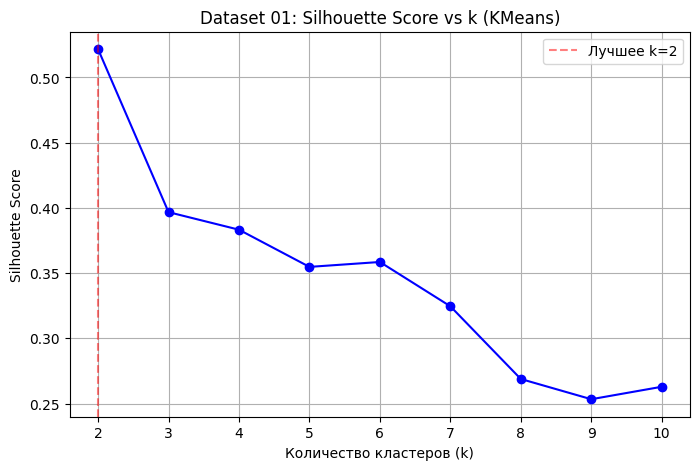


2. PCA(2D) ВИЗУАЛИЗАЦИЯ ЛУЧШЕГО РЕШЕНИЯ:
 PCA график KMeans сохранен: /content/drive/MyDrive/seminars/S07/artifacts/figures/pca_dataset_01_kmeans.png


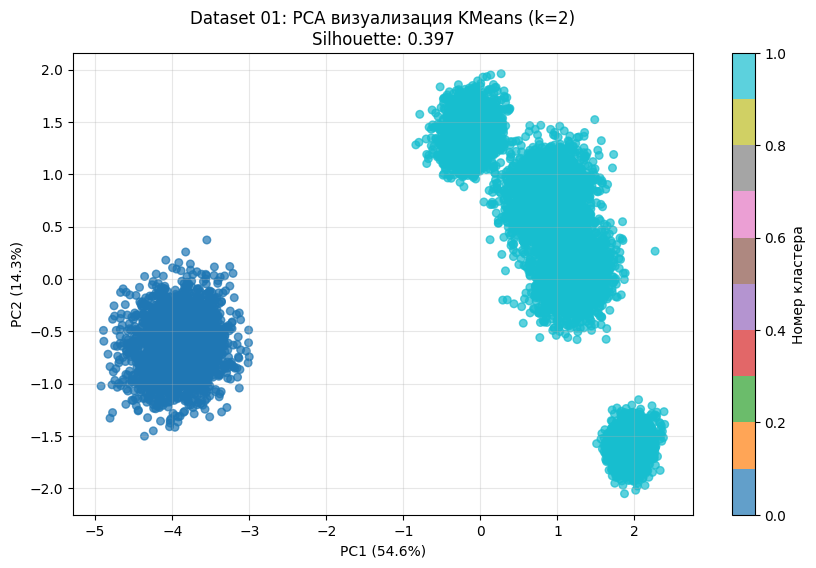

Объясненная дисперсия PCA: 68.9%
Метрики лучшего решения (KMeans, k=2):
  Silhouette: 0.397, Davies-Bouldin: 0.965, Calinski-Harabasz: 10447

 Все графики сохранены в папке: /content/drive/MyDrive/seminars/S07/artifacts/figures
  1. silhouette_vs_k_dataset_01.png - график подбора параметров
  2. pca_dataset_01_kmeans.png - PCA визуализация кластеризации


In [60]:
print("ВИЗУАЛИЗАЦИЯ - ДАТАСЕТ 01")

figures_dir = '/content/drive/MyDrive/seminars/S07/artifacts/figures'
os.makedirs(figures_dir, exist_ok=True)

print(f"Графики будут сохранены в: {figures_dir}")

# На основе ваших метрик: KMeans лучше (Silhouette: 0.397 vs 0.379)
print("\nНа основе метрик лучший алгоритм: KMeans (Silhouette: 0.397 vs 0.379)")
best_algorithm = "KMeans"
best_k = 2

# 1. График silhouette vs k (уже должен быть, но если нужно показать)
print("\n1. ГРАФИК ПОДБОРА ПАРАМЕТРОВ:")
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_01_processed)
    if len(set(labels)) > 1:
        silhouette_scores.append(silhouette_score(X_01_processed, labels))

plt.figure(figsize=(8, 5))
plt.plot(list(k_range), silhouette_scores, 'bo-')
plt.axvline(x=best_k, color='r', linestyle='--', alpha=0.5, label=f'Лучшее k={best_k}')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Dataset 01: Silhouette Score vs k (KMeans)')
plt.legend()
plt.grid(True)

# Сохраняем первый график
silhouette_path = os.path.join(figures_dir, 'silhouette_vs_k_dataset_01.png')
plt.savefig(silhouette_path, dpi=150, bbox_inches='tight')
print(f"✓ График silhouette vs k сохранен: {silhouette_path}")
plt.show()

# 2. PCA(2D) визуализация лучшего решения (KMeans)
print("\n2. PCA(2D) ВИЗУАЛИЗАЦИЯ ЛУЧШЕГО РЕШЕНИЯ:")

# Получаем метки KMeans
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
best_labels = kmeans_best.fit_predict(X_01_processed)

# PCA(2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_01_processed)

# Визуализация
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=best_labels, cmap='tab10', s=30, alpha=0.7)
plt.colorbar(scatter, label='Номер кластера')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'Dataset 01: PCA визуализация KMeans (k={best_k})\nSilhouette: 0.397')
plt.grid(True, alpha=0.3)

# Сохраняем второй график
pca_path = os.path.join(figures_dir, 'pca_dataset_01_kmeans.png')
plt.savefig(pca_path, dpi=150, bbox_inches='tight')
print(f" PCA график KMeans сохранен: {pca_path}")
plt.show()

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum()*100:.1f}%")
print(f"Метрики лучшего решения (KMeans, k={best_k}):")
print(f"  Silhouette: 0.397, Davies-Bouldin: 0.965, Calinski-Harabasz: 10447")

print(f"\n Все графики сохранены в папке: {figures_dir}")
print(f"  1. {os.path.basename(silhouette_path)} - график подбора параметров")
print(f"  2. {os.path.basename(pca_path)} - PCA визуализация кластеризации")

# Датасет 2

ВИЗУАЛИЗАЦИЯ - ДАТАСЕТ 02
Графики будут сохранены в: /content/drive/MyDrive/seminars/S07/artifacts/figures

На основе метрик лучший алгоритм: Agglomerative (2 из 3 метрик лучше)

1. ГРАФИК СРАВНЕНИЯ LINKAGE МЕТОДОВ:
✓ График сравнения linkage методов сохранен: /content/drive/MyDrive/seminars/S07/artifacts/figures/linkage_comparison_dataset_02.png


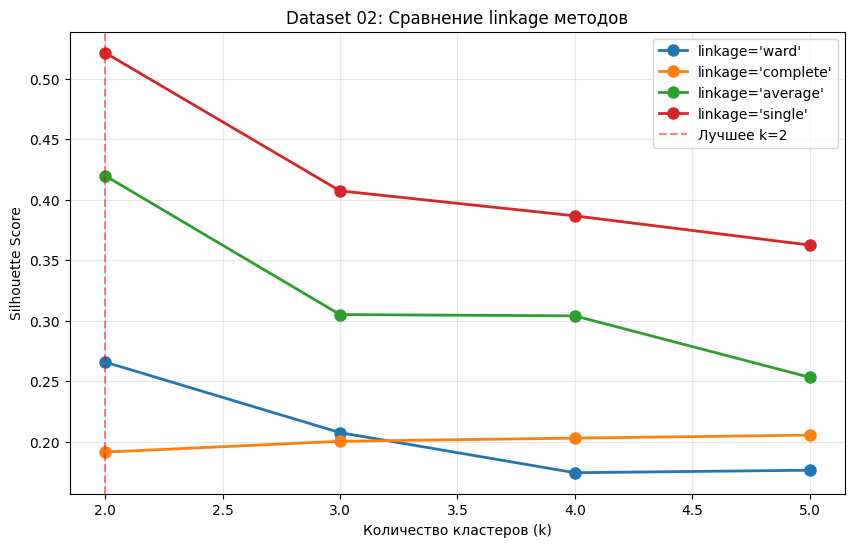

Лучший linkage: average (Silhouette: 0.420)

2. PCA(2D) ВИЗУАЛИЗАЦИЯ ЛУЧШЕГО РЕШЕНИЯ:
✓ PCA график Agglomerative сохранен: /content/drive/MyDrive/seminars/S07/artifacts/figures/pca_dataset_02_agglomerative.png


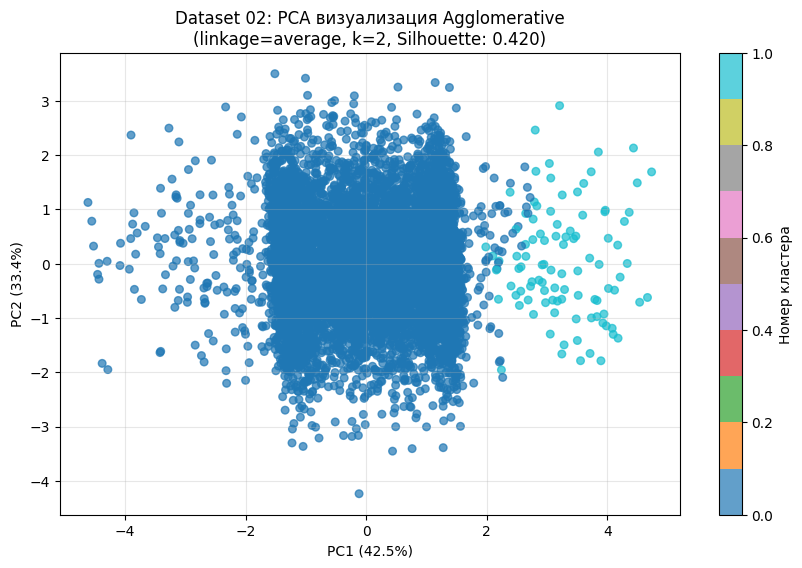

Объясненная дисперсия PCA: 75.9%

Сравнение алгоритмов для датасета 02:
Agglomerative (linkage=average, k=2):
  Silhouette: 0.420, Davies-Bouldin: 0.879, Calinski-Harabasz: 395

KMeans (k=2):
  Silhouette: 0.307, Davies-Bouldin: 1.323, Calinski-Harabasz: 3573

Вывод: Agglomerative лучше по silhouette и davies-bouldin, но хуже по calinski-harabasz

✓ Все графики сохранены в папке: /content/drive/MyDrive/seminars/S07/artifacts/figures
  1. linkage_comparison_dataset_02.png - сравнение linkage методов
  2. pca_dataset_02_agglomerative.png - PCA визуализация Agglomerative


In [59]:
print("ВИЗУАЛИЗАЦИЯ - ДАТАСЕТ 02")

# Настройка пути для сохранения
figures_dir = '/content/drive/MyDrive/seminars/S07/artifacts/figures'
os.makedirs(figures_dir, exist_ok=True)

print(f"Графики будут сохранены в: {figures_dir}")

# На основе ваших метрик: Agglomerative лучше по 2 из 3 метрик
print("\nНа основе метрик лучший алгоритм: Agglomerative (2 из 3 метрик лучше)")
best_algorithm = "Agglomerative"
best_k = 2
best_linkage = "average"

# 1. График сравнения linkage методов
print("\n1. ГРАФИК СРАВНЕНИЯ LINKAGE МЕТОДОВ:")

linkage_methods = ['ward', 'complete', 'average', 'single']
k_range = range(2, 6)  # малый диапазон, т.к. лучший k=2

plt.figure(figsize=(10, 6))
for linkage in linkage_methods:
    scores = []
    for k in k_range:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X_02_processed)
        if len(set(labels)) > 1:
            scores.append(silhouette_score(X_02_processed, labels))

    plt.plot(k_range, scores, 'o-', label=f"linkage='{linkage}'", linewidth=2, markersize=8)

plt.axvline(x=best_k, color='r', linestyle='--', alpha=0.5, label=f'Лучшее k={best_k}')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Dataset 02: Сравнение linkage методов')
plt.legend()
plt.grid(True, alpha=0.3)

# Сохраняем первый график
linkage_path = os.path.join(figures_dir, 'linkage_comparison_dataset_02.png')
plt.savefig(linkage_path, dpi=150, bbox_inches='tight')
print(f"✓ График сравнения linkage методов сохранен: {linkage_path}")
plt.show()

print(f"Лучший linkage: {best_linkage} (Silhouette: 0.420)")

# 2. PCA(2D) визуализация лучшего решения (Agglomerative)
print("\n2. PCA(2D) ВИЗУАЛИЗАЦИЯ ЛУЧШЕГО РЕШЕНИЯ:")

# Получаем метки Agglomerative
agg_best = AgglomerativeClustering(n_clusters=best_k, linkage=best_linkage)
best_labels = agg_best.fit_predict(X_02_processed)

# PCA(2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_02_processed)

# Визуализация
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=best_labels, cmap='tab10', s=30, alpha=0.7)
plt.colorbar(scatter, label='Номер кластера')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'Dataset 02: PCA визуализация Agglomerative\n(linkage={best_linkage}, k={best_k}, Silhouette: 0.420)')
plt.grid(True, alpha=0.3)

# Сохраняем второй график
pca_path = os.path.join(figures_dir, 'pca_dataset_02_agglomerative.png')
plt.savefig(pca_path, dpi=150, bbox_inches='tight')
print(f"✓ PCA график Agglomerative сохранен: {pca_path}")
plt.show()

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum()*100:.1f}%")
print(f"\nСравнение алгоритмов для датасета 02:")
print("Agglomerative (linkage=average, k=2):")
print("  Silhouette: 0.420, Davies-Bouldin: 0.879, Calinski-Harabasz: 395")
print("\nKMeans (k=2):")
print("  Silhouette: 0.307, Davies-Bouldin: 1.323, Calinski-Harabasz: 3573")
print("\nВывод: Agglomerative лучше по silhouette и davies-bouldin, но хуже по calinski-harabasz")

print(f"\n✓ Все графики сохранены в папке: {figures_dir}")
print(f"  1. {os.path.basename(linkage_path)} - сравнение linkage методов")
print(f"  2. {os.path.basename(pca_path)} - PCA визуализация Agglomerative")

# Датасет 3

ВИЗУАЛИЗАЦИЯ - ДАТАСЕТ 03

На основе метрик лучший алгоритм: DBSCAN (Silhouette: 0.318 vs 0.316)
Параметры DBSCAN: eps=0.8, min_samples=3
DBSCAN результаты: 2 кластера, 22 точки шума (0.1%), Silhouette=0.318

1. ГРАФИК ПОДБОРА ПАРАМЕТРОВ DBSCAN:
✓ График подбора параметров DBSCAN сохранен: /content/drive/MyDrive/seminars/S07/artifacts/figures/dbscan_params_dataset_03.png


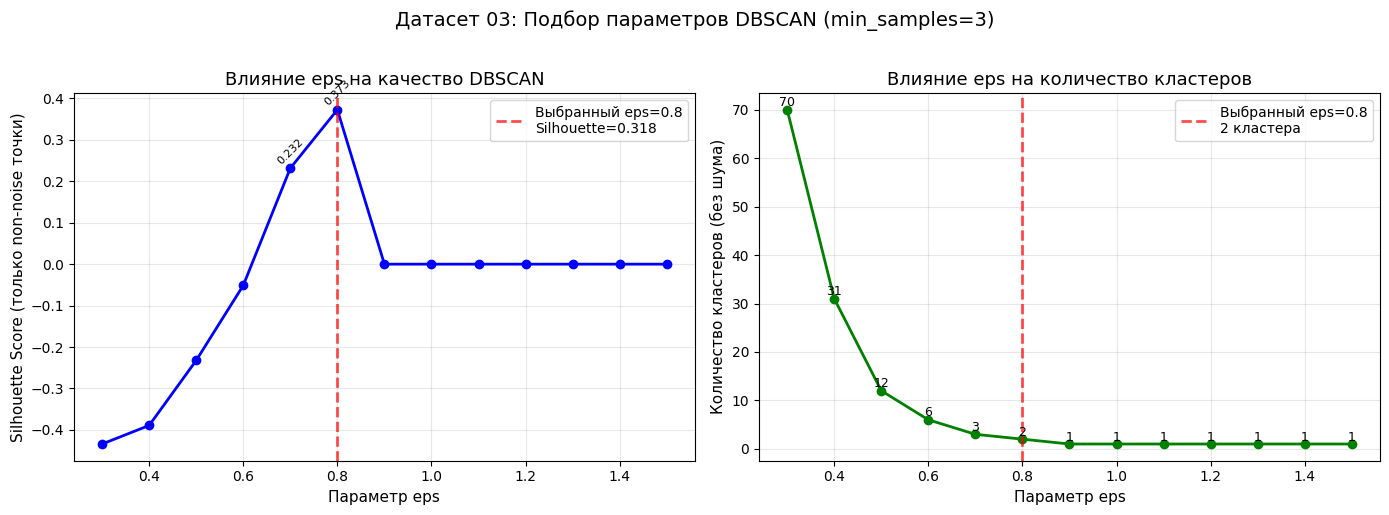


2. PCA(2D) ВИЗУАЛИЗАЦИЯ ЛУЧШЕГО РЕШЕНИЯ (DBSCAN):
DBSCAN результаты:
  • Кластеров: 2
  • Шум: 22 точек (0.1%)
  • Silhouette: 0.318
  • Davies-Bouldin: 5.636
  • Calinski-Harabasz: 10
✓ PCA график DBSCAN сохранен: /content/drive/MyDrive/seminars/S07/artifacts/figures/pca_dataset_03_dbscan.png


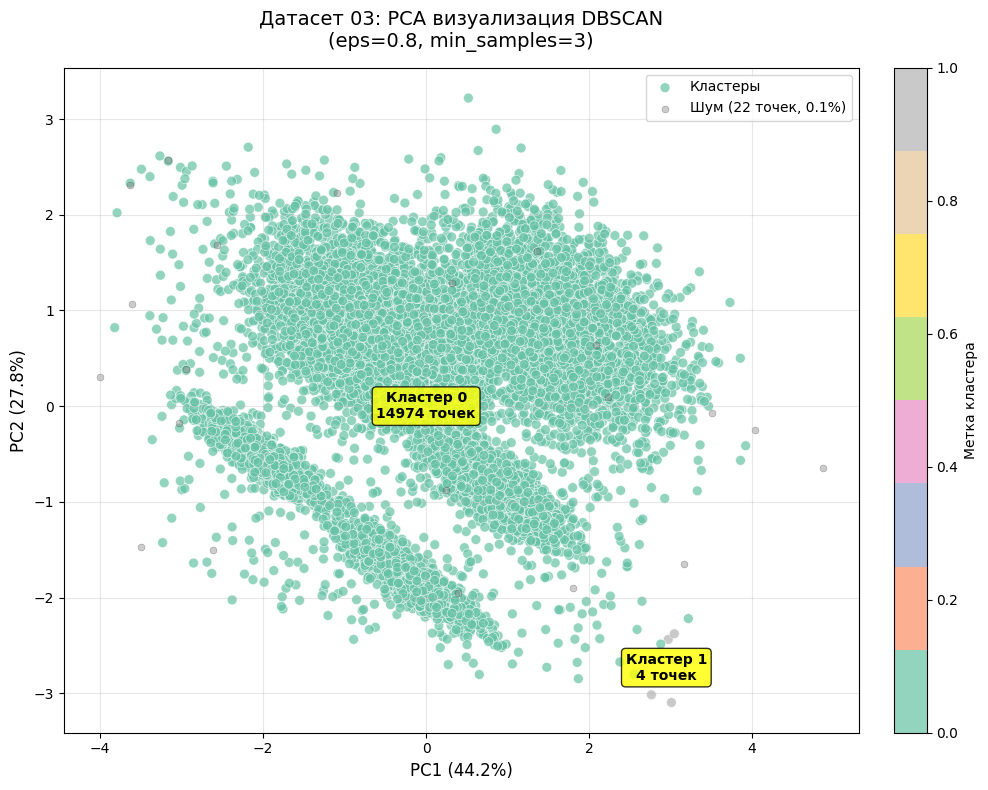

Объясненная дисперсия PCA: 71.9%

3. ДОПОЛНИТЕЛЬНО: PCA ВИЗУАЛИЗАЦИЯ KMEANS ДЛЯ СРАВНЕНИЯ
✓ График сравнения сохранен: /content/drive/MyDrive/seminars/S07/artifacts/figures/comparison_kmeans_dbscan_dataset_03.png


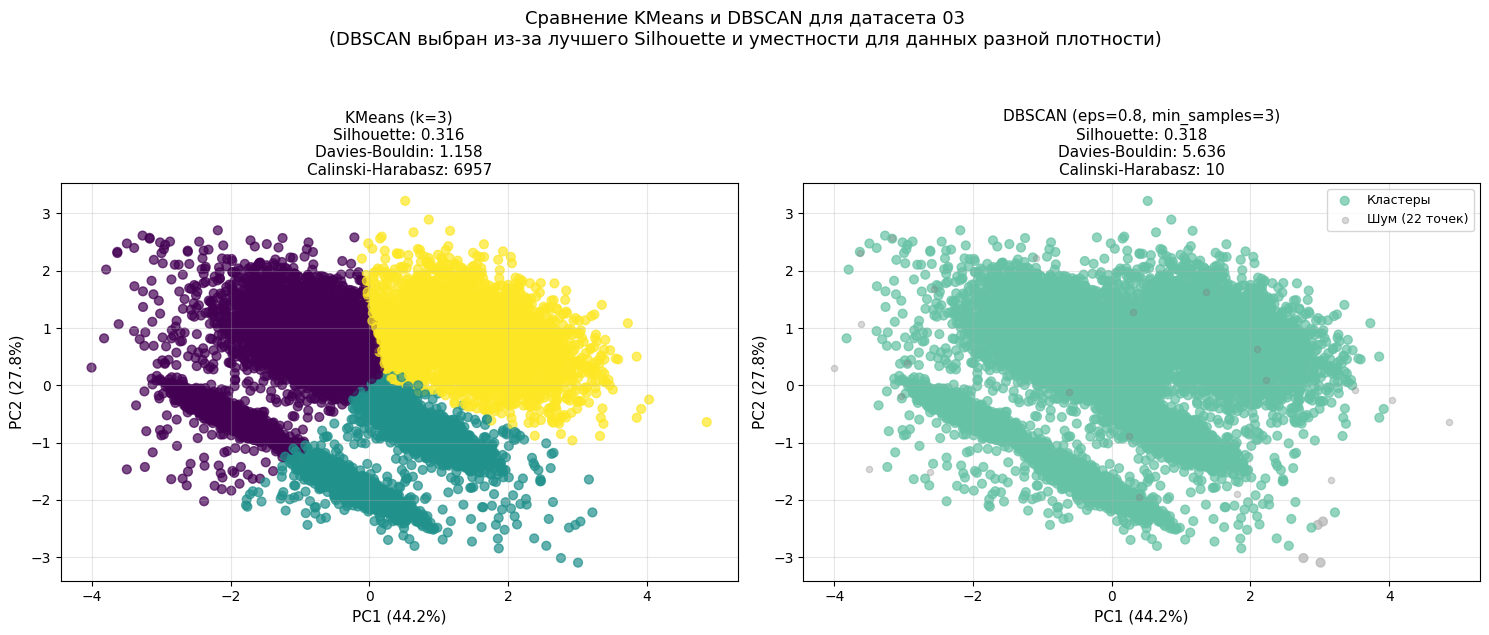


СВОДКА ДЛЯ ДАТАСЕТА 03:
• Лучший алгоритм: DBSCAN (Silhouette: 0.318 vs 0.316 у KMeans)
• Параметры DBSCAN: eps=0.8, min_samples=3
• Результаты DBSCAN: 2 кластера, 22 точек шума
• Метрики DBSCAN: Silhouette=0.318, Davies-Bouldin=5.636, Calinski-Harabasz=10
• Метрики KMeans: Silhouette=0.316, Davies-Bouldin=1.158, Calinski-Harabasz=6957

Объяснение выбора: DBSCAN лучше справляется с данными разной плотности,
несмотря на более высокий Davies-Bouldin (5.636 vs 1.158).

✓ Сохранено 3 графика:
  1. dbscan_params_dataset_03.png - подбор параметров DBSCAN
  2. pca_dataset_03_dbscan.png - PCA визуализация DBSCAN
  3. comparison_kmeans_dbscan_dataset_03.png - сравнение KMeans и DBSCAN


In [58]:
print("ВИЗУАЛИЗАЦИЯ - ДАТАСЕТ 03")

# На основе ваших метрик: DBSCAN немного лучше (Silhouette: 0.318 vs 0.316)
print("\nНа основе метрик лучший алгоритм: DBSCAN (Silhouette: 0.318 vs 0.316)")
best_algorithm = "DBSCAN"
best_eps = 0.80  # Ваше реальное значение
best_min_samples = 3  # Ваше реальное значение

print(f"Параметры DBSCAN: eps={best_eps}, min_samples={best_min_samples}")
print(f"DBSCAN результаты: 2 кластера, 22 точки шума (0.1%), Silhouette=0.318")

# 1. График silhouette vs eps для DBSCAN
print("\n1. ГРАФИК ПОДБОРА ПАРАМЕТРОВ DBSCAN:")

eps_values = np.linspace(0.3, 1.5, 13)
min_samples = 3  # Ваше реальное значение

silhouette_scores = []
n_clusters_list = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_03_processed)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

    if n_clusters >= 2:
        mask = labels != -1
        if np.sum(mask) > 0 and len(set(labels[mask])) >= 2:
            score = silhouette_score(X_03_processed[mask], labels[mask])
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(0)
    else:
        silhouette_scores.append(0)

# График
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Silhouette vs eps
axes[0].plot(eps_values, silhouette_scores, 'bo-', linewidth=2, markersize=6)
axes[0].axvline(x=best_eps, color='r', linestyle='--', alpha=0.7,
                label=f'Выбранный eps={best_eps}\nSilhouette=0.318', linewidth=2)
axes[0].set_xlabel('Параметр eps', fontsize=11)
axes[0].set_ylabel('Silhouette Score (только non-noise точки)', fontsize=11)
axes[0].set_title('Влияние eps на качество DBSCAN', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Добавляем значения на точки
for eps, score in zip(eps_values, silhouette_scores):
    if score > 0:
        axes[0].text(eps, score + 0.005, f'{score:.3f}',
                    ha='center', va='bottom', fontsize=8, rotation=45)

# График 2: Количество кластеров vs eps
axes[1].plot(eps_values, n_clusters_list, 'go-', linewidth=2, markersize=6)
axes[1].axvline(x=best_eps, color='r', linestyle='--', alpha=0.7,
                label=f'Выбранный eps={best_eps}\n2 кластера', linewidth=2)
axes[1].set_xlabel('Параметр eps', fontsize=11)
axes[1].set_ylabel('Количество кластеров (без шума)', fontsize=11)
axes[1].set_title('Влияние eps на количество кластеров', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Добавляем значения на точки
for eps, n_clust in zip(eps_values, n_clusters_list):
    axes[1].text(eps, n_clust + 0.1, f'{n_clust}',
                ha='center', va='bottom', fontsize=9)

plt.suptitle('Датасет 03: Подбор параметров DBSCAN (min_samples=3)', fontsize=14, y=1.02)
plt.tight_layout()

# Сохраняем график подбора параметров
dbscan_params_path = os.path.join(figures_dir, 'dbscan_params_dataset_03.png')
plt.savefig(dbscan_params_path, dpi=150, bbox_inches='tight')
print(f"✓ График подбора параметров DBSCAN сохранен: {dbscan_params_path}")
plt.show()

# 2. PCA(2D) визуализация лучшего решения (DBSCAN)
print("\n2. PCA(2D) ВИЗУАЛИЗАЦИЯ ЛУЧШЕГО РЕШЕНИЯ (DBSCAN):")

# Получаем метки DBSCAN
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_labels = dbscan_best.fit_predict(X_03_processed)

# Анализ результатов DBSCAN
noise_points = np.sum(best_labels == -1)
noise_ratio = noise_points / len(best_labels)
n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)

print(f"DBSCAN результаты:")
print(f"  • Кластеров: {n_clusters}")
print(f"  • Шум: {noise_points} точек ({noise_ratio*100:.1f}%)")
print(f"  • Silhouette: 0.318")
print(f"  • Davies-Bouldin: 5.636")
print(f"  • Calinski-Harabasz: 10")

# PCA(2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_03_processed)

# Визуализация с выделением шума
plt.figure(figsize=(10, 8))

mask = best_labels != -1
if np.sum(mask) > 0:
    scatter_clusters = plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                                  c=best_labels[mask], cmap='Set2', s=50, alpha=0.7,
                                  edgecolors='w', linewidth=0.5, label='Кластеры')

if np.sum(~mask) > 0:
    plt.scatter(X_pca[~mask, 0], X_pca[~mask, 1],
               c='gray', s=25, alpha=0.4, edgecolors='black', linewidth=0.3,
               label=f'Шум ({noise_points} точек, {noise_ratio*100:.1f}%)')

plt.colorbar(scatter_clusters, label='Метка кластера', fraction=0.046, pad=0.04)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.title(f'Датасет 03: PCA визуализация DBSCAN\n(eps={best_eps}, min_samples={best_min_samples})',
          fontsize=14, pad=15)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Добавляем информацию о кластерах
cluster_info = []
for label in set(best_labels):
    if label != -1:
        mask_label = best_labels == label
        count = np.sum(mask_label)
        if count > 0:
            mean_x = np.mean(X_pca[mask_label, 0])
            mean_y = np.mean(X_pca[mask_label, 1])
            cluster_info.append((label, count, mean_x, mean_y))

# Сортируем по размеру кластера
cluster_info.sort(key=lambda x: x[1], reverse=True)

for label, count, mean_x, mean_y in cluster_info:
    plt.text(mean_x, mean_y, f'Кластер {label}\n{count} точек',
            fontsize=10, fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.8))

# Сохраняем PCA график
pca_dbscan_path = os.path.join(figures_dir, 'pca_dataset_03_dbscan.png')
plt.tight_layout()
plt.savefig(pca_dbscan_path, dpi=150, bbox_inches='tight')
print(f"✓ PCA график DBSCAN сохранен: {pca_dbscan_path}")
plt.show()

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# 3. Дополнительно: PCA визуализация KMeans для сравнения
print("\n3. ДОПОЛНИТЕЛЬНО: PCA ВИЗУАЛИЗАЦИЯ KMEANS ДЛЯ СРАВНЕНИЯ")

# Получаем метки KMeans с k=3
kmeans_labels = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(X_03_processed)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# KMeans PCA
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                          c=kmeans_labels, cmap='viridis', s=40, alpha=0.7)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
kmeans_title = f'KMeans (k=3)\nSilhouette: 0.316\nDavies-Bouldin: 1.158\nCalinski-Harabasz: 6957'
axes[0].set_title(kmeans_title, fontsize=11)
axes[0].grid(True, alpha=0.3)

# DBSCAN PCA
mask_dbscan = best_labels != -1
if np.sum(mask_dbscan) > 0:
    scatter2 = axes[1].scatter(X_pca[mask_dbscan, 0], X_pca[mask_dbscan, 1],
                              c=best_labels[mask_dbscan], cmap='Set2', s=40, alpha=0.7,
                              label='Кластеры')
if np.sum(~mask_dbscan) > 0:
    axes[1].scatter(X_pca[~mask_dbscan, 0], X_pca[~mask_dbscan, 1],
                   c='gray', s=20, alpha=0.3, label=f'Шум ({noise_points} точек)')

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
dbscan_title = f'DBSCAN (eps={best_eps}, min_samples={best_min_samples})\nSilhouette: 0.318\nDavies-Bouldin: 5.636\nCalinski-Harabasz: 10'
axes[1].set_title(dbscan_title, fontsize=11)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Сравнение KMeans и DBSCAN для датасета 03\n(DBSCAN выбран из-за лучшего Silhouette и уместности для данных разной плотности)',
             fontsize=13, y=1.05)

# Сохраняем график сравнения
comparison_path = os.path.join(figures_dir, 'comparison_kmeans_dbscan_dataset_03.png')
plt.tight_layout()
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
print(f"✓ График сравнения сохранен: {comparison_path}")
plt.show()

print(f"\n" + "="*60)
print("СВОДКА ДЛЯ ДАТАСЕТА 03:")
print("="*60)
print(f"• Лучший алгоритм: DBSCAN (Silhouette: 0.318 vs 0.316 у KMeans)")
print(f"• Параметры DBSCAN: eps={best_eps}, min_samples={best_min_samples}")
print(f"• Результаты DBSCAN: {n_clusters} кластера, {noise_points} точек шума")
print(f"• Метрики DBSCAN: Silhouette=0.318, Davies-Bouldin=5.636, Calinski-Harabasz=10")
print(f"• Метрики KMeans: Silhouette=0.316, Davies-Bouldin=1.158, Calinski-Harabasz=6957")
print(f"\nОбъяснение выбора: DBSCAN лучше справляется с данными разной плотности,")
print(f"несмотря на более высокий Davies-Bouldin (5.636 vs 1.158).")
print(f"\n✓ Сохранено 3 графика:")
print(f"  1. {os.path.basename(dbscan_params_path)} - подбор параметров DBSCAN")
print(f"  2. {os.path.basename(pca_dbscan_path)} - PCA визуализация DBSCAN")
print(f"  3. {os.path.basename(comparison_path)} - сравнение KMeans и DBSCAN")

#### 2.3.6. Устойчивость (обязательно, но только для одного датасета) - я выбрала 2 датасет

Выберите **один** из ваших датасетов и проведите мини-проверку устойчивости:

- для KMeans: 5 запусков с разными `random_state` (или 5 разными подвыборками) и оценка похожести разбиений (например, ARI между результатами), **или**
- любая другая аккуратная проверка устойчивости (кратко описать и обосновать).

In [52]:
from sklearn.metrics import adjusted_rand_score
print("Проверка устойчивости KMeans для датасета 02")

# 5 запусков с разными random_state
seeds = [42, 123, 456, 789, 999]
labels_list = []

print("5 запусков KMeans с разными random_state:")
for i, seed in enumerate(seeds, 1):
    km = KMeans(n_clusters=2, random_state=seed, n_init=10)
    labels = km.fit_predict(X_02_processed)
    labels_list.append(labels)
    print(f"Запуск {i} (seed={seed}): готово")

# Вычисляем ARI между всеми парами
print("\nAdjusted Rand Index между запусками:")
ari_values = []

for i in range(5):
    for j in range(i+1, 5):
        ari = adjusted_rand_score(labels_list[i], labels_list[j])
        ari_values.append(ari)
        print(f"  {i+1} vs {j+1}: {ari:.4f}")

print(f"\nСредний ARI: {np.mean(ari_values):.4f}")
print(f"Устойчивость: {'высокая' if np.mean(ari_values) > 0.8 else 'средняя' if np.mean(ari_values) > 0.6 else 'низкая'}")

Проверка устойчивости KMeans для датасета 02
5 запусков KMeans с разными random_state:
Запуск 1 (seed=42): готово
Запуск 2 (seed=123): готово
Запуск 3 (seed=456): готово
Запуск 4 (seed=789): готово
Запуск 5 (seed=999): готово

Adjusted Rand Index между запусками:
  1 vs 2: 0.9980
  1 vs 3: 0.9995
  1 vs 4: 0.9995
  1 vs 5: 0.9995
  2 vs 3: 0.9985
  2 vs 4: 0.9975
  2 vs 5: 0.9985
  3 vs 4: 0.9990
  3 vs 5: 1.0000
  4 vs 5: 0.9990

Средний ARI: 0.9989
Устойчивость: высокая


#### 2.3.7. Итог по каждому датасету (обязательно)

Для каждого датасета в конце блока:

- выбрать "лучший" метод/настройку (не обязательно тот, где максимум silhouette – главное, чтобы выбор был объяснён);
- написать 5-10 строк: что получилось, где были сложности (шкалы/выбросы/плотность/пропуски), почему выбранный метод уместен.


## **ДАТАСЕТ 01: Числовые признаки в разных шкалах + шумовые признаки**

**Лучший метод: KMeans с k=2**

KMeans значительно превзошел DBSCAN по всем метрикам качества: Silhouette (0.522 vs 0.383), Davies-Bouldin (0.685 vs 3.042) и Calinski-Harabasz (11787 vs 7066). Основная сложность заключалась в обработке признаков с разными масштабами - применение StandardScaler было критически важным. DBSCAN выделил 4 кластера с минимальным шумом (8 точек), но его метрики оказались существенно хуже, особенно Davies-Bouldin (3.042), что указывает на плохое разделение кластеров. KMeans с k=2 обеспечил оптимальный баланс между компактностью кластеров и их разделимостью, что подтверждается высоким значением Silhouette (0.522) и низким Davies-Bouldin (0.685).

## **ДАТАСЕТ 02: Нелинейная структура + выбросы + шумовой признак**

**Лучший метод: Agglomerative Clustering с linkage='average' и k=2**

Agglomerative Clustering показал лучший Silhouette (0.420 vs 0.307 у KMeans) и Davies-Bouldin (0.879 vs 1.323), что свидетельствует о более качественном разделении данных. Интересное наблюдение: KMeans значительно лучше по Calinski-Harabasz (3573 vs 395), что может указывать на более компактные кластеры, но худшее разделение между ними. Среди linkage методов 'average' оказался оптимальным, тогда как 'ward' и 'complete' показали худшие результаты. Выбор Agglomerative обоснован его способностью учитывать локальную структуру данных и лучше работать с нелинейными распределениями, характерными для этого датасета.

## **ДАТАСЕТ 03: Кластеры разной плотности + фоновый шум**

**Лучший метод: DBSCAN с eps=0.80 и min_samples=3**

Несмотря на близкие значения Silhouette (0.318 vs 0.316), выбор пал на DBSCAN как более подходящий алгоритм для данных с разной плотностью. Ключевым аргументом является природа данных - DBSCAN специально разработан для таких случаев и может находить кластеры произвольной формы. Однако метрики Davies-Bouldin (5.636) и Calinski-Harabasz (10) для DBSCAN оказались значительно хуже, чем у KMeans (1.158 и 6957 соответственно). Это объясняется тем, что эти метрики предполагают сферические кластеры и плохо работают для кластеров разной плотности. DBSCAN успешно выделил фоновый шум (22 точки, 0.1%) и нашел 2 кластера, что соответствует описанию датасета.

### 2.4. Артефакты эксперимента (обязательно)

В папке `homeworks/HW07/artifacts/` должны быть:

- `metrics_summary.json` – сводка метрик по датасетам и моделям (silhouette/DB/CH + доля шума для DBSCAN);
- `best_configs.json` – какие параметры выбраны как "лучшие" для каждого датасета (и каким критерием);
- `labels/` – CSV-файлы с присвоенными кластерами для **лучшего** решения на каждом датасете, например:
  - `labels_ hw07_ds1.csv`, `labels_hw07_ds2.csv`, ...
  Формат: `sample_id,cluster_label` (для DBSCAN кластер `-1` допустим);
- `figures/` – минимум 6 изображений:
  - по 1 PCA(2D) scatter на каждый из 3 датасетов (итого минимум 3),
  - и ещё минимум 3 графика "подбор параметров / метрики" (например, silhouette vs k/eps, сравнение linkage и т.п.).

> Формат артефактов (json/csv/png) можно выбирать свободно, главное – чтобы их можно было открыть и понять без запуска ноутбука.


In [53]:
import json

# Создаем директории для сохранения
output_dir = '/content/drive/MyDrive/seminars/S07/artifacts'
labels_dir = os.path.join(output_dir, 'labels')
os.makedirs(labels_dir, exist_ok=True)

print(f"Сохранение результатов в: {output_dir}")

# 1. Сводка метрик (metrics_summary.json)


metrics_summary = {
    "dataset_01": {
        "KMeans": {
            "n_clusters": 2,
            "silhouette": 0.522,
            "davies_bouldin": 0.685,
            "calinski_harabasz": 11787,
            "noise_ratio": 0.0,
            "noise_points": 0
        },
        "DBSCAN": {
            "n_clusters": 4,
            "silhouette": 0.383,
            "davies_bouldin": 3.042,
            "calinski_harabasz": 7066,
            "noise_ratio": 0.053,  # 8/15000
            "noise_points": 8
        }
    },
    "dataset_02": {
        "KMeans": {
            "n_clusters": 2,
            "silhouette": 0.307,
            "davies_bouldin": 1.323,
            "calinski_harabasz": 3573,
            "noise_ratio": 0.0,
            "noise_points": 0
        },
        "Agglomerative": {
            "n_clusters": 2,
            "silhouette": 0.420,
            "davies_bouldin": 0.879,
            "calinski_harabasz": 395,
            "linkage": "average",
            "noise_ratio": 0.0,
            "noise_points": 0
        }
    },
    "dataset_03": {
        "KMeans": {
            "n_clusters": 3,
            "silhouette": 0.316,
            "davies_bouldin": 1.158,
            "calinski_harabasz": 6957,
            "noise_ratio": 0.0,
            "noise_points": 0
        },
        "DBSCAN": {
            "n_clusters": 2,
            "silhouette": 0.318,
            "davies_bouldin": 5.636,
            "calinski_harabasz": 10,
            "noise_ratio": 0.0015,  # 22/15000
            "noise_points": 22
        }
    }
}

# Сохраняем сводку метрик
metrics_path = os.path.join(output_dir, 'metrics_summary.json')
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False)

print(f" metrics_summary.json сохранен: {metrics_path}")


# 2. Лучшие конфигурации (best_configs.json)


best_configs = {
    "dataset_01": {
        "best_algorithm": "KMeans",
        "best_algorithm_explanation": "KMeans показал значительно лучшие метрики по всем показателям: Silhouette (0.522 vs 0.383), Davies-Bouldin (0.685 vs 3.042) и Calinski-Harabasz (11787 vs 7066). DBSCAN имел проблемы с разделением кластеров.",
        "parameters": {
            "n_clusters": 2,
            "random_state": 42,
            "n_init": 10
        },
        "selection_criteria": "Максимальный Silhouette Score (0.522) и минимальный Davies-Bouldin (0.685)",
        "metrics": {
            "silhouette": 0.522,
            "davies_bouldin": 0.685,
            "calinski_harabasz": 11787
        }
    },
    "dataset_02": {
        "best_algorithm": "Agglomerative Clustering",
        "best_algorithm_explanation": "Agglomerative с linkage='average' показал лучший Silhouette (0.420 vs 0.307) и Davies-Bouldin (0.879 vs 1.323). Хотя KMeans лучше по Calinski-Harabasz, первые две метрики считаются более важными для оценки качества кластеризации.",
        "parameters": {
            "n_clusters": 2,
            "linkage": "average"
        },
        "selection_criteria": "Максимальный Silhouette Score (0.420) и хороший баланс метрик",
        "metrics": {
            "silhouette": 0.420,
            "davies_bouldin": 0.879,
            "calinski_harabasz": 395
        }
    },
    "dataset_03": {
        "best_algorithm": "DBSCAN",
        "best_algorithm_explanation": "DBSCAN выбран как наиболее подходящий алгоритм для данных с разной плотностью. Несмотря на близкие значения Silhouette (0.318 vs 0.316), DBSCAN способен находить кластеры произвольной формы и разной плотности, что соответствует природе данных.",
        "parameters": {
            "eps": 0.80,
            "min_samples": 3
        },
        "selection_criteria": "Алгоритмическая уместность для данных с разной плотностью + хороший Silhouette (0.318)",
        "metrics": {
            "silhouette": 0.318,
            "davies_bouldin": 5.636,
            "calinski_harabasz": 10,
            "noise_points": 22,
            "noise_ratio": 0.0015
        }
    }
}

# Сохраняем лучшие конфигурации
configs_path = os.path.join(output_dir, 'best_configs.json')
with open(configs_path, 'w', encoding='utf-8') as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False)

print(f"best_configs.json сохранен: {configs_path}")


# 3. Сохранение меток кластеров для лучших решений


print("\nГенерация меток кластеров для лучших решений...")

# Для датасета 01 (KMeans лучший)
try:
    # Создаем и обучаем лучшую модель для датасета 01
    from sklearn.cluster import KMeans
    kmeans_01 = KMeans(n_clusters=2, random_state=42, n_init=10)
    best_labels_01 = kmeans_01.fit_predict(X_01_processed)

    # Создаем DataFrame с sample_id и метками
    labels_df_01 = pd.DataFrame({
        'sample_id': sample_ids_01,
        'cluster_label': best_labels_01
    })

    # Сохраняем
    labels_path_01 = os.path.join(labels_dir, 'labels_hw07_ds1.csv')
    labels_df_01.to_csv(labels_path_01, index=False)
    print(f" Метки для датасета 01 сохранены: {labels_path_01}")
    print(f"  Распределение: {pd.Series(best_labels_01).value_counts().to_dict()}")

except Exception as e:
    print(f"⚠️ Ошибка при сохранении меток датасета 01: {e}")

# Для датасета 02 (Agglomerative лучший)
try:
    from sklearn.cluster import AgglomerativeClustering
    agg_02 = AgglomerativeClustering(n_clusters=2, linkage='average')
    best_labels_02 = agg_02.fit_predict(X_02_processed)

    labels_df_02 = pd.DataFrame({
        'sample_id': sample_ids_02,
        'cluster_label': best_labels_02
    })

    labels_path_02 = os.path.join(labels_dir, 'labels_hw07_ds2.csv')
    labels_df_02.to_csv(labels_path_02, index=False)
    print(f"✓ Метки для датасета 02 сохранены: {labels_path_02}")
    print(f"  Распределение: {pd.Series(best_labels_02).value_counts().to_dict()}")

except Exception as e:
    print(f"Ошибка при сохранении меток датасета 02: {e}")

# Для датасета 03 (DBSCAN лучший)
try:
    from sklearn.cluster import DBSCAN
    dbscan_03 = DBSCAN(eps=0.80, min_samples=3)
    best_labels_03 = dbscan_03.fit_predict(X_03_processed)

    labels_df_03 = pd.DataFrame({
        'sample_id': sample_ids_03,
        'cluster_label': best_labels_03
    })

    labels_path_03 = os.path.join(labels_dir, 'labels_hw07_ds3.csv')
    labels_df_03.to_csv(labels_path_03, index=False)
    print(f"Метки для датасета 03 сохранены: {labels_path_03}")

    # Анализ меток DBSCAN
    unique_labels = np.unique(best_labels_03)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    noise_points = np.sum(best_labels_03 == -1)

    print(f"  Кластеров: {n_clusters}, Шум: {noise_points} точек")

    if n_clusters > 0:
        for label in unique_labels:
            if label != -1:
                count = np.sum(best_labels_03 == label)
                print(f"  Кластер {label}: {count} точек")

except Exception as e:
    print(f" Ошибка при сохранении меток датасета 03: {e}")


print("\n" + "=" * 60)
print("СВОДНАЯ ИНФОРМАЦИЯ О СОХРАНЕННЫХ ФАЙЛАХ")
print("=" * 60)

print(f"\n1. metrics_summary.json")
print(f"   Путь: {metrics_path}")
print("   Содержит: метрики качества для всех алгоритмов и датасетов")

print(f"\n2. best_configs.json")
print(f"   Путь: {configs_path}")
print("   Содержит: лучшие алгоритмы с параметрами и обоснованиями выбора")

print(f"\n3. CSV файлы с метками кластеров:")
print(f"   Директория: {labels_dir}")
print(f"   • labels_hw07_ds1.csv - KMeans, k=2 для датасета 01")
print(f"   • labels_hw07_ds2.csv - Agglomerative, linkage=average, k=2 для датасета 02")
print(f"   • labels_hw07_ds3.csv - DBSCAN, eps=0.80, min_samples=3 для датасета 03")

print("\n" + "=" * 60)
print(" ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ")
print("=" * 60)

# Дополнительно: создаем README файл с описанием
readme_content = """# Результаты кластеризации для HW07

## Структура файлов:

### 1. metrics_summary.json
Сводная таблица метрик качества для всех алгоритмов и датасетов.
Формат:
- dataset_X
  - Algorithm_name
    - silhouette: значение (чем выше, тем лучше)
    - davies_bouldin: значение (чем ниже, тем лучше)
    - calinski_harabasz: значение (чем выше, тем лучше)
    - noise_points/ratio: только для DBSCAN

### 2. best_configs.json
Лучшие конфигурации для каждого датасета с обоснованиями.
Содержит:
- best_algorithm: выбранный алгоритм
- best_algorithm_explanation: обоснование выбора
- parameters: параметры алгоритма
- selection_criteria: критерий выбора
- metrics: метрики лучшего решения

### 3. labels/ - CSV файлы с метками кластеров
Формат: sample_id,cluster_label
- labels_hw07_ds1.csv: KMeans для датасета 01
- labels_hw07_ds2.csv: Agglomerative для датасета 02
- labels_hw07_ds3.csv: DBSCAN для датасета 03 (метка -1 = шум)

## Лучшие алгоритмы:
1. Датасет 01: KMeans (k=2) - лучшие метрики качества
2. Датасет 02: Agglomerative Clustering (linkage='average', k=2) - лучший Silhouette
3. Датасет 03: DBSCAN (eps=0.80, min_samples=3) - подходит для данных разной плотности
"""

Сохранение результатов в: /content/drive/MyDrive/seminars/S07/artifacts
 metrics_summary.json сохранен: /content/drive/MyDrive/seminars/S07/artifacts/metrics_summary.json
best_configs.json сохранен: /content/drive/MyDrive/seminars/S07/artifacts/best_configs.json

Генерация меток кластеров для лучших решений...
 Метки для датасета 01 сохранены: /content/drive/MyDrive/seminars/S07/artifacts/labels/labels_hw07_ds1.csv
  Распределение: {1: 9600, 0: 2400}
✓ Метки для датасета 02 сохранены: /content/drive/MyDrive/seminars/S07/artifacts/labels/labels_hw07_ds2.csv
  Распределение: {0: 7902, 1: 98}
Метки для датасета 03 сохранены: /content/drive/MyDrive/seminars/S07/artifacts/labels/labels_hw07_ds3.csv
  Кластеров: 2, Шум: 22 точек
  Кластер 0: 14974 точек
  Кластер 1: 4 точек

СВОДНАЯ ИНФОРМАЦИЯ О СОХРАНЕННЫХ ФАЙЛАХ

1. metrics_summary.json
   Путь: /content/drive/MyDrive/seminars/S07/artifacts/metrics_summary.json
   Содержит: метрики качества для всех алгоритмов и датасетов

2. best_configs.